# Analytical code for the RF model

In [14]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from mpltools import annotation
import torch
import tqdm
import itertools

from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import scipy.integrate as integrate
import scipy.special as special
import mpmath

%load_ext autoreload
%autoreload 2

cmap = plt.get_cmap('viridis')
plt.rcParams.update(plt.rcParamsDefault)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font',       family='serif')          # controls default text sizes
plt.rc('font',       size=2*MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes',  titlesize=2*MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes',  labelsize=2*MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=2*SMALL_SIZE)    # legend fontsize
plt.rc('figure',titlesize=2*BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('Spectral_r')

savedir = './figs/'
if not os.path.exists(savedir): os.mkdir(savedir)
datadir = './data/'

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dict_product(d):
    keys = d.keys()
    for element in itertools.product(*d.values()):
        yield dict(zip(keys, element))
        
def select_data(data,constraints):
    data1 = data
    for k,v in constraints.items():
        try:
            data1 = data1[data1[k]==v]
        except:
            print("Error on {}, constraint={}, value={}".format(k,v,data1[k]))
    return data1

def df_to_arrays(df, x_label, y_label, z_label):
    x_vals = df[x_label].unique()
    y_vals = df[y_label].unique()
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros((len(x_vals),len(y_vals)))
    for line in df.iterrows():
        line = line[1]
        x, y, z = line[x_label], line[y_label], line[z_label]
        i, j = find(x_vals, x), find(y_vals, y)
        Z[i,j] = z
    return X, Y, Z

def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

# Gaussian equivalence

In [3]:
# Non-linearities and their respective coefficients
NL = {'relu', 'sign', 'tanh', 'erf'}
COEFFICIENTS = {'relu': (1/np.sqrt(2*np.pi), 0.5, np.sqrt((np.pi-2)/(4*np.pi))), 
               'erf': (0, 2/np.sqrt(3*np.pi), 0.200364), 'tanh': (0, 0.605706, 0.165576),
               'sign': (0, np.sqrt(2/np.pi), np.sqrt(1-2/np.pi)), 'linear':(0,1,0),'abs':(np.sqrt(2/np.pi),0,np.sqrt(1-2/np.pi))}

def get_coef(nl, cs):
    if type(nl)==str:
        return COEFFICIENTS[nl]
    else:
        return (0, nl**0.5, (1-nl)**0.5)
    
def get_coef_blocks(nl, cs, ds):
    cs, ds = np.array(cs), np.array(ds)
    V = np.sum(cs*ds)
    kappa_0 = integrate.quad(lambda x : activation(x, nl)     * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0]
    kappa_1 = integrate.quad(lambda x : activation(x, nl) * x * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0] / V
    kappa_2 = integrate.quad(lambda x : activation(x, nl)**2  * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0]
    kappa_star = np.sqrt(kappa_2 - kappa_0**2 - kappa_1**2 * V)
    return kappa_0, kappa_1, kappa_star
        
def activation(x, nonlinearity):
    if nonlinearity == 'linear':
        return x
    if nonlinearity == 'sign':
        return np.sign(x)
    elif nonlinearity == 'relu':
        return np.maximum(x, 0)
    elif nonlinearity =='erf':
        return erf(x)
    elif nonlinearity == 'tanh':
        return np.tanh(x)
    else:
        print('nonlinearity not known')

# Random matrix theory for block matrices

In [4]:
# Stieltjes transform and its derivative for gaussian and orthogonal features.
from scipy.optimize import fsolve, minimize, LinearConstraint

def stieltjes_g(z, gamma, F='gaussian'):
    g, dg = 0, 0
    z = gamma * z 
    if F=='gaussian':
        det = np.sqrt((z-gamma-1)**2 - 4*gamma)
        g = (1-z-gamma-det)/(2*z*gamma)
        dg = -1/(2*z*gamma) * (1 + (z-gamma-1)/det + (1-z-gamma-det)/z) 
    elif F == 'orthogonal':        
        if gamma > 1:
            g = -(1-1/gamma)/z +1/gamma *  1/(gamma-z)
            dg = (1-1/gamma)/z**2 + 1/gamma *  1/(gamma-z)**2
        else:
            g = 1/(1-z)
            dg = 1/(1-z)**2
        
    return gamma*g, gamma**2 *dg

def stieltjes_g_block(z, gamma, Vs, ds, F='gaussian'):
    g, dg = 0, 0
    z = gamma * z 
    
    Vs, ds = np.array(Vs), np.array(ds)
    
    def equations(p):
        qs, dqs = p[:len(p)//2], p[len(p)//2:]
        omega = 1 - np.sum(ds * Vs * qs * gamma)
        eqs = ds*z*omega*qs - Vs*ds*qs - ds*omega
        domega = - np.sum(ds * Vs * dqs * gamma)
        deqs = ds*(omega*qs + z*domega*qs + z*omega*dqs) - Vs*ds*dqs - ds*domega
        return np.concatenate([eqs, deqs])
    
    sol = -fsolve(equations, (np.ones(len(Vs))/z,np.ones(len(Vs))))
    qs, dqs = sol[:len(sol)//2], sol[len(sol)//2:]
    g = ds * qs
    dg = ds * dqs
            
    return gamma*g, gamma**2 *dg

In [5]:
# mhat_x #
def xstar(x, y,omega,V):
    return (x-omega)**2/(2*V) + np.log(1+np.exp(-x*y))

def f_mhat_plus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_plus = minimize_scalar(lambda x: xstar(x, 1, ω, V))['x']
    return np.exp(-ωstar**2/(2*Vstar))*(λstar_plus - ω)

def f_mhat_minus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_minus = minimize_scalar(lambda x: xstar(x, -1, ω, V))['x']
    return np.exp(-ωstar**2/(2*Vstar))*(λstar_minus - ω)

def integrate_for_mhat(M, Q, V, Vstar, delta):
    f1 = lambda ξ: f_mhat_plus(ξ, M, Q, V, Vstar) * np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    f2 = lambda ξ: f_mhat_minus(ξ, M, Q, V, Vstar) * np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    I = integrate.quad(lambda x : (1.-2*delta)*(f1(x)-f2(x)), -10, 10)[0]
    return I*(1/np.sqrt(2*np.pi*Vstar))

# Vhat_x #
def f_Vhat_plus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_plus = minimize_scalar(lambda x: xstar(x, 1, ω, V))['x']
    return (1/(1/V + (1/4) * (1/np.cosh(λstar_plus/2)**2))) * (1 + special.erf(ωstar/np.sqrt(2*Vstar)))

def f_Vhat_minus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_minus = minimize_scalar(lambda x: xstar(x, -1, ω, V))['x']
    return (1/(1/V + (1/4) * (1/np.cosh(-λstar_minus/2)**2))) * (1 - special.erf(ωstar/np.sqrt(2*Vstar)))

def integrate_for_Vhat(M, Q, V, Vstar, delta):
    f1 = lambda ξ: f_Vhat_plus(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    f2 = lambda ξ: f_Vhat_minus(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    I = integrate.quad(lambda x : f1(x)+f2(x), -10, 10)[0]
    return (1/2) * I

# Qhat_x#
def f_qhat_plus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_plus = minimize_scalar(lambda x: xstar(x, 1, ω, V))['x']
    return (1 + special.erf(ωstar/np.sqrt(2*Vstar))) * (λstar_plus - ω)**2

def f_qhat_minus(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_minus = minimize_scalar(lambda x: xstar(x, -1, ω, V))['x']
    return (1 - special.erf(ωstar/np.sqrt(2*Vstar))) * (λstar_minus - ω)**2

def integrate_for_Qhat(M, Q, V, Vstar, delta):
    f1 = lambda ξ: f_qhat_plus(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    f2 = lambda ξ: f_qhat_minus(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    I = integrate.quad(lambda x : f1(x)+f2(x), -10, 10)[0]
    return (1/2) * I

#Train
def Integrand_training_error_plus_logistic(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_plus = np.float(mpmath.findroot(lambda λstar_plus: λstar_plus - ω - V/(1 + np.exp(np.float(λstar_plus))), 10e-10))
    return (1 + special.erf(ωstar/np.sqrt(2*Vstar))) * np.log(1 + np.exp(-λstar_plus))

def Integrand_training_error_minus_logistic(ξ, M, Q, V, Vstar):
    ω = np.sqrt(Q)*ξ
    ωstar = (M/np.sqrt(Q))*ξ
    λstar_minus = np.float(mpmath.findroot(lambda λstar_minus: λstar_minus - ω + V/(1 + np.exp(-np.float(λstar_minus))), 10e-10))
    return (1 - special.erf(ωstar/np.sqrt(2*Vstar))) * np.log(1 + np.exp(λstar_minus))

def traning_error_logistic(M, Q, V, Vstar):
    f1 = lambda ξ: Integrand_training_error_plus_logistic(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    f2 = lambda ξ: Integrand_training_error_minus_logistic(ξ, M, Q, V, Vstar)* np.exp(-ξ**2/2) * (1/np.sqrt(2*np.pi))
    I = integrate.quad(lambda x : f1(x)+f2(x), -10, 10)[0]
    return (1/2)*I

# Saddle-point equations

In [6]:
def iterate_se(alpha, gamma, lamb, delta=0, nl='erf', F='gaussian',
               max_iter=int(1e3), eps=1e-5, init_condition='uninformed', task='classification', loss='square',
              cs=[1,2], ds=[.5, .5], betas=[1,1], coef_damping=.5):
    """ 
    Update state evolution equations. 
    
    Parameters:
    * eps = threshold to reach convergence.
    * max_iter = maximum number of steps if convergence not reached.
    """
    
    # Initialise qu and qv
    Vx = np.zeros((max_iter,len(cs)))
    qx = np.zeros((max_iter,len(cs)))
    mx = np.zeros((max_iter,len(cs)))

    Vw = np.zeros(max_iter)
    qw = np.zeros(max_iter)
    
    ones = ds
    if init_condition == 'uninformed':
        Vx[0], qx[0], mx[0] = 0.001*ones, 0.001*ones, 0.001*ones
        Vw[0], qw[0] = 0.001, 0.001
        
    elif init_condition == 'informed':
        Vx[0], qx[0], mx[0] = 0.999*ones, 0.999*ones, 0.999*ones
        Vw[0], qw[0] = 0.999, 0.999
        
    for t in range(max_iter - 1):
        if task=='classification':
            Vxtmp, qxtmp, mxtmp, Vwtmp, qwtmp = update_classification(Vx[t], qx[t], mx[t], Vw[t], qw[t], 
                                                          alpha, gamma, lamb, delta, nl=nl, F=F, cs=cs, ds=ds, betas=betas, iter=t, loss=loss)          
        elif task=='regression':
            Vxtmp, qxtmp, mxtmp, Vwtmp, qwtmp = update_regression(Vx[t], qx[t], mx[t], Vw[t], qw[t],
                                                          alpha, gamma, lamb, delta, nl=nl, F=F, cs=cs, ds=ds, betas=betas, iter=t)  
            
        def damping(q_new, q_old):
            return (1 - coef_damping) * q_new + coef_damping * q_old

        
        Vx[t + 1], qx[t + 1], mx[t+1] = damping(Vxtmp, Vx[t]), damping(qxtmp, qx[t]), damping(mxtmp, mx[t])
        Vw[t + 1], qw[t + 1] = damping(Vwtmp, Vw[t]), damping(qwtmp, qw[t])
                
        diff = np.abs(Vx[t + 1] - Vx[t]).sum() + np.abs(qx[t + 1] - qx[t]).sum() + np.abs(mx[t + 1] - mx[t]).sum()
        diff += np.abs(Vw[t + 1] - Vw[t]) + np.abs(qw[t + 1] - qw[t])
        
        if diff < eps or np.isnan(diff):
            break
            
        #print(Vx[t], qx[t], mx[t], Vw[t], qw[t])
        #if t==2: break
                
    return Vx[t], qx[t], mx[t], Vw[t], qw[t], t

In [7]:
def update_classification(Vx, qx, mx, Vw, qw, alpha, gamma, lamb, delta, nl='erf', loss='square', F='gaussian', cs=[1,1], ds=[0.5,0.5], betas=[1,1], iter=0):
    
    M = mu1 *    (mx * cs).sum()
    Q = mu1**2 * (qx * cs).sum() + mustar**2 * qw 
    V = mu1**2 * (Vx * cs).sum() + mustar**2 * Vw
    rho = (cs * betas * ds).sum()
    noise_factor = 1-2*delta
    
    if loss=='square':
        c1 = 1/(1+V)
        mxhat = cs*alpha/gamma * mu1 * c1 * np.sqrt(2/np.pi) * noise_factor
        Vxhat = cs*alpha/gamma * mu1**2 * c1
        qxhat = cs*alpha/gamma * mu1**2 * c1**2 * (rho + Q - 2*noise_factor*M * np.sqrt(2/np.pi))    
        Vwhat = (alpha/gamma) * mustar**2 * c1
        qwhat = (alpha/gamma) * mustar**2 * c1**2 * (rho + Q - 2*noise_factor*M * np.sqrt(2/np.pi))
    elif loss=='logistic':
        Vstar = rho - M**2/Q
        Im = integrate_for_mhat(M, Q, V, Vstar, delta)
        Iv = integrate_for_Vhat(M, Q, V, Vstar, delta)
        Iq = integrate_for_Qhat(M, Q, V, Vstar, delta)
        
        mxhat = cs*(alpha/gamma)*(mu1/V)*Im
        Vxhat = cs*(alpha/gamma)*(mu1**2/V) - cs*(alpha/gamma)*(mu1**2/V**2) * Iv
        qxhat = cs*(alpha/gamma)*(mu1**2/V**2) * Iq
        
        Vwhat = (alpha/gamma)*(mustar**2/V) - (alpha/gamma)*(mustar**2/V**2) * Iv
        qwhat = (alpha/gamma)*(mustar**2/V**2) * Iq
    else:
        raise
  
    z = (lamb+Vwhat)
    g, dg = stieltjes_g_block(-z, gamma, Vxhat, ds, F=F)
    
    Vxnew =  (ds - z * g)/Vxhat
    mxnew =  (betas * mxhat) * Vxnew 
    qxnew =  (betas * mxhat**2 + qxhat)/Vxhat**2 * (ds - 2*z*g + z**2 * dg) - qwhat/(lamb+Vwhat)/Vxhat * (-z*g + z**2 * dg)
        
    Vwnew = (1/gamma - 1 + z*np.sum(g))/(Vwhat+lamb)
    qwnew = qwhat/(lamb+Vwhat)**2 * (1/gamma - 1 + z**2 * np.sum(dg)) - np.sum((betas * mxhat**2 + qxhat)/(Vxhat*(lamb+Vwhat)) * (-z*g+ z**2 * dg))
  
    return Vxnew, qxnew, mxnew, Vwnew, qwnew


def update_regression(Vx, qx, mx, Vw, qw, alpha, gamma, lamb, delta, nl='erf',  F='gaussian', cs=[1,2], ds=[.5, .5], betas=[1,1], iter=0):

    M = mu1 *    (mx * cs).sum()
    Q = mu1**2 * (qx * cs).sum() + mustar**2 * qw 
    V = mu1**2 * (Vx * cs).sum() + mustar**2 * Vw
    rho = (cs * betas * ds).sum()
    
    c1 = 1/(1+V)

    mxhat = cs*alpha/gamma * mu1    * c1
    Vxhat = cs*alpha/gamma * mu1**2 * c1 
    qxhat = cs*alpha/gamma * mu1**2 * c1**2 * (rho + Q + delta - 2*M) 
    
    Vwhat = alpha/gamma * mustar**2 * c1
    qwhat = alpha/gamma * mustar**2 * c1**2 * (rho + Q + delta - 2*M)
    
    z = (lamb+Vwhat)
    g, dg = stieltjes_g_block(-z, gamma, Vxhat, ds, F=F)
    
    Vxnew =  (ds - z * g)/Vxhat
    mxnew =  (betas * mxhat) * Vxnew 
    qxnew =  (betas * mxhat**2 + qxhat)/Vxhat**2 * (ds - 2*z*g + z**2 * dg) - qwhat/(lamb+Vwhat)/Vxhat * (-z*g + z**2 * dg)
        
    Vwnew = (1/gamma - 1 + z*np.sum(g))/(Vwhat+lamb)
    qwnew = qwhat/(lamb+Vwhat)**2 * (1/gamma - 1 + z**2 * np.sum(dg)) - np.sum((betas * mxhat**2 + qxhat)/(Vxhat*(lamb+Vwhat)) * (-z*g+ z**2 * dg))

    return Vxnew, qxnew, mxnew, Vwnew, qwnew

# Runs

In [143]:
# VARYING N
Psi1s = [1]
Psi2s = np.logspace(-3,3,60)
rphis = [10]
rxs   = [1,100]
rbs   = [0.01,1,100]

# VARYING P
#Psi2s = [1]
#Psi1s = np.logspace(-3,3,60)
#rphis = [10]
#rxs   = [1,100]
#rbs   = [0.01,1,100]

# VARYING ALIGNMENT
#Psi1s = [100]
#Psi2s = [1]
#rphis = [10]
#rxs   = [100]
#rbs   = np.logspace(-3,3,15)

# VARYING N AND P
#Psi1s = np.logspace(-2,4,15)
#Psi2s = np.logspace(-2,4,15)
#rphis = [100]
#rxs   = [1,10]
#rbs   = [10]

constraints = {'Psi1':Psi1s,
               'Psi2':Psi2s,
               'rphi':rphis,
               'rx':rxs,
               'rb':rbs,
               'lamb':[1e-3],
               'nl':['tanh'],
               'delta':[0.0,0.3],
               'F':['gaussian'],
               'task':['classification'],
               'loss':['square','logistic'],
              }

data = {'task':[], 'loss':[], 'nonlinearity': [], 'F': [], 'alpha': [], 'Psi1': [], 'Psi2': [], 'gamma':[], 'delta':[], 'rphi':[], 'rx':[], 'rb':[],
        'Vx': [], 'qx': [], 'mx': [], 'Vw': [], 'qw': [], 'Q':[], 'M':[], 'V':[], 'te_error':[], 'tr_error':[], 't': [], 'lamb': []}

total = np.prod([len(v) for v in constraints.values()])
for icons, cons in enumerate(dict_product(constraints)):
    if icons%(total//40)==0: print(f'{icons}/{total}', end=' ')

    nonlinearity, Psi1, Psi2, lamb, task, F, delta, rx, rb, rphi, loss = cons['nl'], cons['Psi1'], cons['Psi2'], cons['lamb'], cons['task'], cons['F'], cons['delta'], cons['rx'], cons['rb'], cons['rphi'], cons['loss']
    if rx==1 and rb!=rbs[0]: continue
    if rx==0.1 and rb<1: continue
    if loss == 'logistic' and (task!='classification'): continue

    ds = np.array([1/rphi, 1-1/rphi])
    cs = np.array([rx/(rx*ds[0]+ds[1]), 1/(rx*ds[0]+ds[1])])
    betas = np.array([rb/(rb*ds[0]*cs[0]+ds[1]*cs[1]), 1/(rb*ds[0]*cs[0]+ds[1]*cs[1])])

    mu0, mu1, mustar = get_coef_blocks(nonlinearity, cs, ds)

    alpha = Psi2/Psi1
    gamma = 1/Psi1

    Vx, qx, mx, Vw, qw, t = iterate_se(alpha, gamma, lamb, delta=delta,nl=nonlinearity, 
                                       F=F, init_condition='uninformed', task=task, loss=loss,
                                       cs=cs, ds=ds, betas=betas,
                                       max_iter=int(50), eps=1e-2, coef_damping=0.2)


    rho = (betas * cs * ds).sum()
    M = mu1 *    (mx*cs).sum()
    Q = mu1**2 * (qx*cs).sum() + mustar**2 * qw 
    V = mu1**2 * (Vx*cs).sum() + mustar**2 * Vw 

    if task == 'classification':
        te_error = (1/np.pi) * np.arccos(M/np.sqrt(Q*rho))
        if loss == 'square':
            tr_error = 1/((1+V)**2) * ( te_error + delta/2 ) #(rho + Q - 2 * (1-2*delta) *M ) / (2*(1+V)**2)
        else:
            Vstar = rho - M**2/Q
            tr_error = traning_error_logistic(M, Q, V, Vstar)
    else:
        te_error = (rho + Q - 2*M) / 2
        tr_error = 1/((1+V)**2) * ( te_error + delta/2 )

    if not np.isnan(te_error) and te_error>0:
        for k in data:
            data[k].append(eval(k))
                                                
data = pd.DataFrame.from_dict(data)

0/40 1/40 2/40 3/40 4/40 5/40 6/40 7/40 8/40 9/40 10/40 11/40 12/40 13/40 14/40 15/40 16/40 17/40 18/40 19/40 20/40 21/40 22/40 23/40 24/40 25/40 26/40 27/40 28/40 29/40 30/40 31/40 32/40 33/40 34/40 35/40 36/40 37/40 38/40 39/40 

# Varying $P$ and $N$

To obtain Figs 2, 4 and 5, select the parameters loss, observable and x_axis, then execute the cell below
- Fig 2 : observable = 'te_error'
- Fig 4 : observable = 'tr_error'
- Fig 5 : observable = 'Q' and 'M'

In [37]:
loss = 'logistic' # choose square or logistic
observable = 'te_error' # choose tr_error, te_error, M, Q, V
x_axis = 'sample_wise' # choose sample_wise or parameter_wise

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'classification', 'loss': 'logistic', 'delta': 0.0}


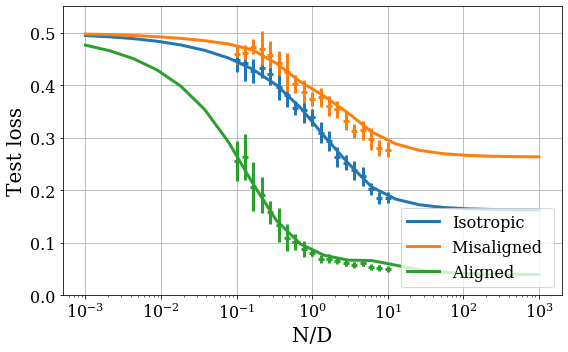

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'classification', 'loss': 'logistic', 'delta': 0.3}


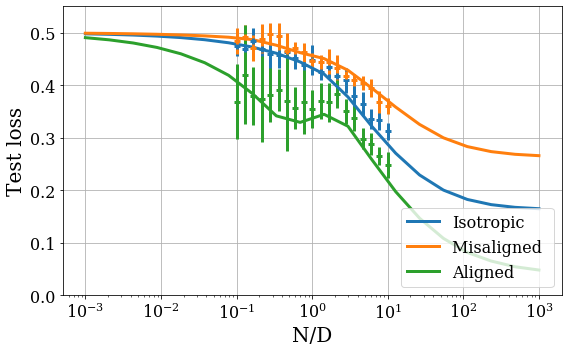

In [38]:
data = torch.load(datadir+x_axis+('_logistic' if loss=='logistic' else '')+'.pkl')
data = pd.DataFrame.from_dict(data)

labels = {'tr_error':'Train loss', 'te_error':'Test loss', 'Q':'Q', 'M':'M'}

parameter_wise = True if len(data['Psi1'].unique())>1 else False
plot_type = 'parameter_wise' if parameter_wise else 'sample_wise'
xkey = 'Psi1' if parameter_wise else 'Psi2'
xlabel = 'P/D' if parameter_wise else 'N/D'

constraints = {
'nonlinearity': list(set(data['nonlinearity'])),
'lamb': sorted(list(set(data['lamb']))),
'task': sorted(list(set(data['task']))),
'loss': sorted(list(set(data['loss']))),
'delta': sorted(list(set(data['delta']))),
}

constraints2 = {
'rx': sorted(list(set(data['rx']))),
'rb': sorted(list(set(data['rb']))),
'rphi': sorted(list(set(data['rphi']))),
}

for cons in dict_product(constraints):
    
    print(cons)
    icolor=0

    fig = plt.figure(figsize=(8,5))
    data1 = select_data(data, cons)
    ax = fig.add_subplot(111)
    if observable in ['Q','M']:
        axins = ax.inset_axes([0.1, 0.5, 0.3, 0.4])

    for cons2 in dict_product(constraints2):
        
        if cons2['rx']==1 and cons2['rb']!=constraints2['rb'][0]: continue
        if cons2['rx']==1:
            label='Isotropic'
        else:
            if cons2['rb'] == 1:  continue#label = 'Normal salient '
            elif cons2['rb'] > 1: label = 'Aligned '
            elif cons2['rb'] < 1: label = 'Misaligned '
        color = 'C%d'%icolor
        icolor+=1

        data2 = select_data(data1, cons2)
        
        ax.plot(data2[xkey], data2[observable], label=label, color=color)

        ax.set_xscale('log')
        ax.set_yscale('log')        
        if cons['task']=='classification': 
            ax.set_yscale('linear')
            if observable=='te_error': ax.set_ylim(0,.55)
        if observable=='tr_error':
            ax.set_yscale('linear')
        ax.set_xlabel(xlabel)
        ylabel = labels[observable]
        ax.set_ylabel(ylabel)
        
        if observable in ['Q','M']:
            axins.plot(data2[xkey], data2[observable], label=label, color=color)
            axins.set_xscale('log')
            axins.set_yscale('log')
            axins.grid(True)
        
        ax.grid(True)
        if observable == 'tr_error':
            ax.set_xlim(5e-2,5e1)
        
        if observable in ['tr_error','te_error']:
            runs = torch.load(datadir+'{}_{}_{}_{}.pyT'.format(plot_type,cons['task'],cons['loss'],cons['delta']))
            run = runs[(cons2['rx'],cons2['rb'])]
            args= run['args']
            x = args['Psi1_list'] if parameter_wise else args['Psi2_list']
            ax.errorbar(x, run[observable], yerr= run[observable+'_std'], color=color, ls='none', marker='+', mew=3)
                    
    ax.legend(loc='lower right')
    plt.tight_layout()    
    plt.savefig(savedir+'agreement_{}_{}_{}_noise{}_lamb{}_{}_{}.pdf'.format(plot_type, observable, cons['nonlinearity'], cons['delta'], cons['lamb'], cons['task'], cons['loss']))
    
    plt.show()

# Varying $r_\beta$

To obtain Fig 3a, execute the cell below

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'classification'}


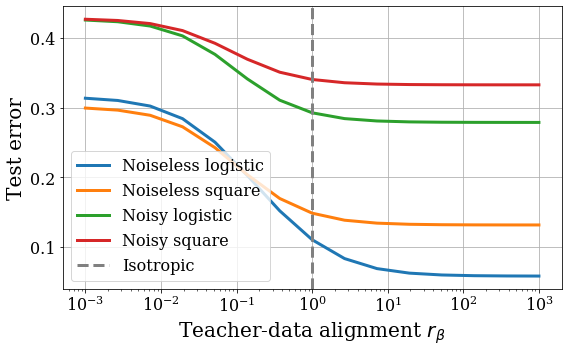

In [40]:
observable = 'te_error'

data = torch.load(datadir+'varying_alignment.pkl')

parameter_wise = True if len(data['Psi1'].unique())>1 else False
plot_type = 'parameter_wise' if parameter_wise else 'sample_wise'
xkey = 'rb'
xlabel = r'Teacher-data alignment $r_\beta$'

constraints = {
'nonlinearity': list(set(data['nonlinearity'])),
'lamb': sorted(list(set(data['lamb']))),
'task': sorted(list(set(data['task']))),
}

constraints2 = {
'delta': sorted(list(set(data['delta']))),
'loss': sorted(list(set(data['loss']))),
}


for cons in dict_product(constraints):
    
    print(cons)
    icolor=0

    fig = plt.figure(figsize=(8,5))
    data1 = select_data(data, cons)
    ax = fig.add_subplot(111)

    for cons2 in dict_product(constraints2):

        data2 = select_data(data1, cons2)
        
        label = 'Noisy ' if cons2['delta'] else 'Noiseless '
        label += cons2['loss']
        ax.plot(data2[xkey], data2[observable], label=label)

        ax.set_xscale('log')
        ax.set_yscale('log')        
        if cons['task']=='classification': 
            ax.set_yscale('linear')
        if train:
            ax.set_yscale('linear')
        ax.set_xlabel(xlabel)
        ylabel = 'Train loss' if train else ('Test loss' if cons['task']=='regression' else 'Test error')
        ax.set_ylabel(ylabel)
        ax.grid(True)
        
    ax.axvline(x=1, color='grey', ls='--', label='Isotropic')
                          
    ax.legend()
    plt.tight_layout()    
    plt.savefig(savedir+'anisotropy_{}_{}_lamb{}.pdf'.format(observable, cons['nonlinearity'], cons['lamb']))
    
    plt.show()

# Phase space

To obtain the phase spaces of Figs 7 and 8, execute the cell below
- Fig 7 : loss = 'square'
- Fig 8 : loss = 'logistic'

In [49]:
loss = 'logistic' # square or logistic
observable = 'te_error' # choose tr_error, te_error, M, Q, V

phase_space_te_error_rx0.01_rb100_relu_noise0.0_lamb0.1_classification_square.pdf


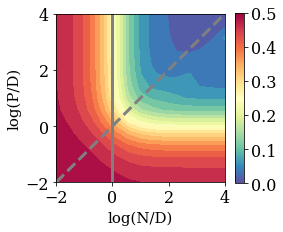

phase_space_te_error_rx1.0_rb100_relu_noise0.0_lamb0.1_classification_square.pdf


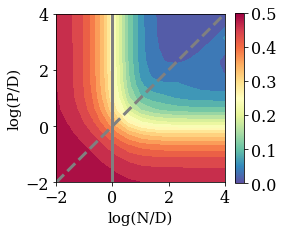

phase_space_te_error_rx100.0_rb100_relu_noise0.0_lamb0.1_classification_square.pdf


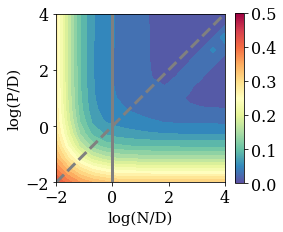

phase_space_te_error_rx0.01_rb100_relu_noise0.3_lamb0.1_classification_square.pdf


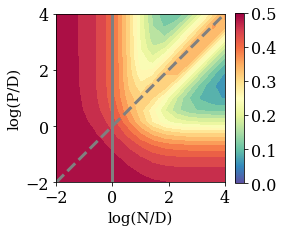

phase_space_te_error_rx1.0_rb100_relu_noise0.3_lamb0.1_classification_square.pdf


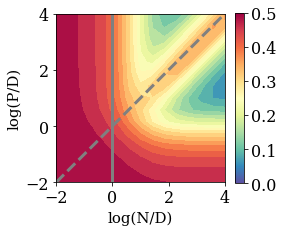

phase_space_te_error_rx100.0_rb100_relu_noise0.3_lamb0.1_classification_square.pdf


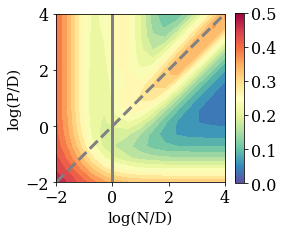

In [50]:
data = torch.load(datadir+'phase_space'+('_logistic' if loss=='logistic' else '')+'.pkl')
data = pd.DataFrame.from_dict(data)

vmin=0 if observable=='te_error' else None
vmax=.5 if observable=='te_error' else None

constraints = {
'nonlinearity': sorted(list(set(data['nonlinearity']))),
'lamb': sorted(list(set(data['lamb']))),
'delta': sorted(list(set(data['delta']))),
'task': sorted(list(set(data['task']))),
'rphi': sorted(list(set(data['rphi']))),
'rx': sorted(list(set(data['rx']))),
'rb': sorted(list(set(data['rb']))),
}

for cons in dict_product(constraints):
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    data1 = select_data(data, cons)
    if len(data1)==0:continue
    
    x = np.log10(data1['Psi2'])
    y = np.log10(data1['Psi1'])
    X, Y, Z = df_to_arrays(data1, 'Psi1', 'Psi2', observable)
    X, Y = np.log10(X), np.log10(Y)
    if observable not in ['tr_error', 'te_error']: Z = np.log10(Z)
    im = ax.contourf(X, Y, Z, cmap=cmap, levels=20, vmin=vmin, vmax=vmax)
    ax.set_xlabel(r'log(N/D)', fontsize=15)
    ax.set_ylabel(r'log(P/D)', fontsize=15)
    ax.axis('scaled')
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(Z)
    m.set_clim(vmin,vmax)
    cbar = plt.colorbar(m, ax=ax, shrink=.7)
    cbar.set_clim(m)
    ax.axvline(x=0, ls='-', color='grey', label='N=D')
    ax.plot([max(min(x), min(y)), min(max(x), max(y))], [max(min(x), min(y)), min(max(x), max(y))], 
                ls='--', color='grey', label='N=P')
    #ax.legend(loc='upper right')
    #ax.legend(loc='lower right', fontsize=12)
                            
    title = 'phase_space_{}_rx{}_rb{}_{}_noise{}_lamb{}_{}_square.pdf'.format(observable, cons['rx'], cons['rb'], cons['nonlinearity'], cons['delta'], cons['lamb'], cons['task'])
    print(title)
    plt.tight_layout()
    plt.savefig(savedir+title)

    plt.show()